In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import r_regression
import seaborn as sn

In [18]:
train_data = pd.read_csv("train.csv")

In [20]:
train_df = train_data[["Elevation", 
                        "Aspect", 
                        "Slope", 
                        "Horizontal_Distance_To_Hydrology", 
                        "Vertical_Distance_To_Hydrology",
                        "Horizontal_Distance_To_Roadways",
                        "Hillshade_9am",
                        "Hillshade_Noon",
                        "Hillshade_3pm",
                        "Horizontal_Distance_To_Fire_Points",
                        "Wilderness_Area1",
                        "Wilderness_Area2",
                        "Wilderness_Area3",
                        "Wilderness_Area4"]]

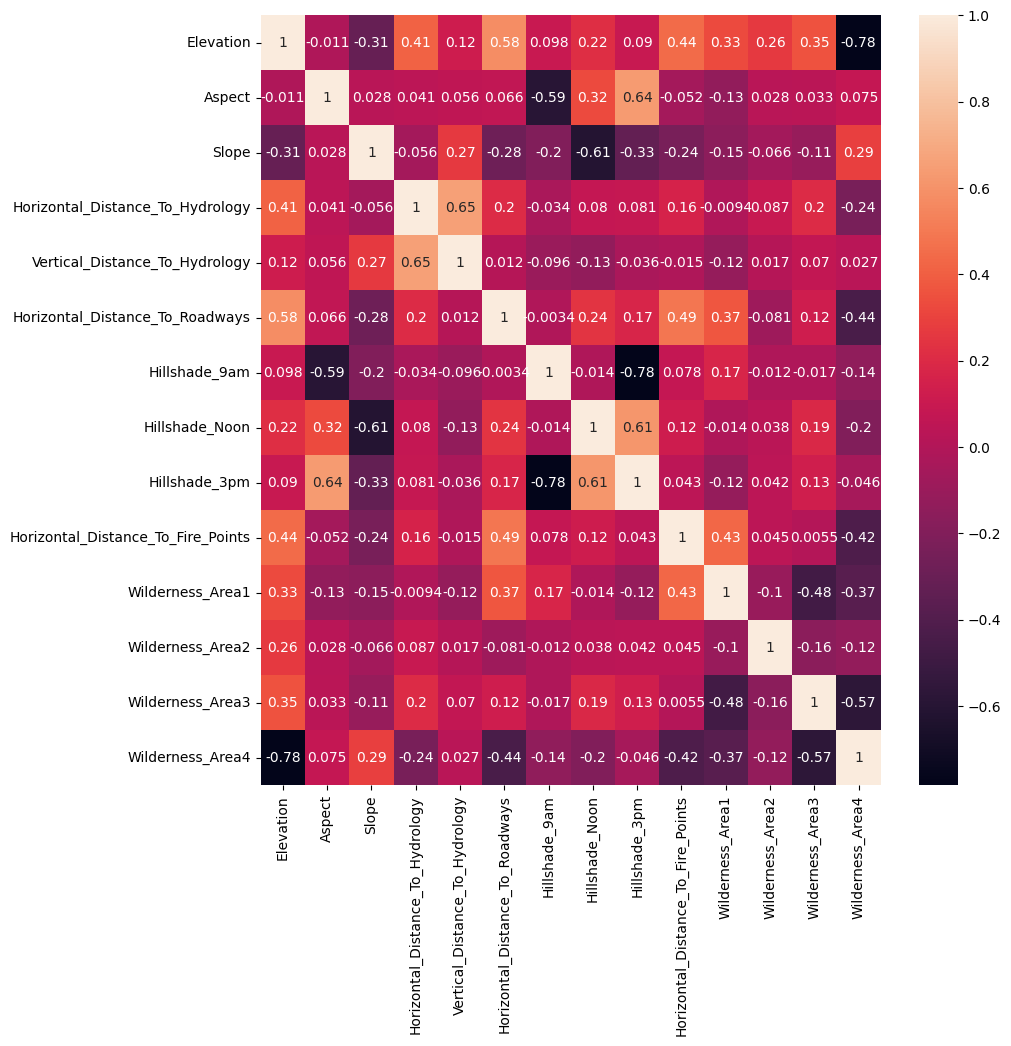

In [21]:
train_df_corr = train_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sn.heatmap(train_df_corr,annot=True, ax=ax)

In [22]:
train_X = train_data.drop(columns=["Id", "Cover_Type"]).to_numpy("float32")
train_Y = train_data["Cover_Type"].to_numpy()

In [24]:
x_mean = np.mean(train_X[0:,0:10], axis=0)
x_scaler = 1 / np.std(train_X[0:,0:10] - x_mean, axis=0)
train_X_scaled = (train_X[0:,0:10] - x_mean) * x_scaler
train_x = np.concatenate((train_X_scaled, train_X[0:,10:]), axis=1)
columns = train_data.drop(columns=["Id", "Cover_Type"]).columns
train_x = pd.DataFrame(train_x, columns=columns)

In [25]:
variances = train_x.var(axis=0)

In [ ]:
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.svm import SVC

# best_acc = 0
# best_x = None
# best_features = None
# for i in range(1,54):
#     best = SelectKBest(f_classif, k=i)
#     x_train_reduced = best.fit_transform(train_x,train_Y)
#     x_train, x_test, y_train, y_test = train_test_split(x_train_reduced, train_Y, test_size=0.3, stratify=train_Y, random_state=11)
#     svm_model = SVC(kernel='rbf', gamma=0.1, C=100)
#     svm_model.fit(x_train, y_train)
#     svm_preds = svm_model.predict(x_test)
#     svm_errs = np.sum(svm_preds != y_test.flatten())
#     svm_acc = 1 - (svm_errs / len(y_test))
#     print(f"Number of features: {i}")
#     print(f"accuracy: {round(svm_acc * 100, 3)}%")
#     print(f"The best features: {best.get_feature_names_out()}")
#     if svm_acc > best_acc:
#         best_acc = svm_acc
#         best_x = x_train
#         best_features = best.get_feature_names_out()


In [26]:
# train_x = train_x[best_features]
train_x = train_x.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(train_x, train_Y, test_size=0.3, stratify=train_Y, random_state=11)

In [141]:
# from joblib import dump
# dump(svm_model, "svm_model.joblib")

['svm_model.joblib']

In [144]:
# with open("best_feature.txt", "w") as bf:
#     for i in range(len(best_features)):
#         bf.write(best_features[i] + ",")

### PCA

In [ ]:
cov_x = np.dot(train_centered_scaled.T, train_centered_scaled)

In [ ]:
eigvals, eigvectors = np.linalg.eig(cov_x)

In [ ]:
r_squared = [eigvals[i] / sum(eigvals) for i in range(len(eigvals))]
plt.bar(range(50), r_squared[0:50])

In [ ]:
pca_model = PCA(50)
pca_model.fit(train_centered_scaled)
print(pca_model.explained_variance_ratio_)

In [ ]:
t1 = np.dot(train_centered_scaled, eigvectors[0:,0:1])
t2 = np.dot(train_centered_scaled, eigvectors[0:,1:2])
plt.scatter(t1,t2, c=labels)

In [ ]:
scores = np.concatenate((t1,t2), axis=1)

### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn_model.fit(x_train, y_train)
preds = knn_model.predict(x_test)
errs = np.sum(preds != y_test.flatten())
accuracy = 1 - (errs / len(y_test))
print(f"accuracy: {round(accuracy * 100, 3)}%")

accuracy: 76.499%


### Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_test)
dt_err = np.sum(dt_pred != y_test.flatten())
dt_acc = 1 - (dt_err / len(y_test))
print(f"accuracy: {round(dt_acc * 100, 3)}%")

accuracy: 77.778%


### SVM

In [29]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', gamma=0.1, C=100)
svm_model.fit(x_train, y_train)
svm_preds = svm_model.predict(x_test)
svm_errs = np.sum(svm_preds != y_test.flatten())
svm_acc = 1 - (svm_errs / len(y_test))
print(f"accuracy: {round(svm_acc * 100, 3)}%")

accuracy: 83.422%


In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_features="sqrt")
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)
rf_errs = np.sum(rf_preds != y_test.flatten())
rf_acc = 1 - (rf_errs / len(y_test))
print(f"accuracy: {round(rf_acc * 100, 3)}%")

accuracy: 86.001%


In [46]:
from joblib import dump
dump(rf, "rf_model.joblib")

['rf_model.joblib']

In [47]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('svm', SVC(kernel='rbf', gamma=0.1, C=100)),
    ('knn', KNeighborsClassifier(n_neighbors=7)),
    ('random_forest', RandomForestClassifier(n_estimators=500)),
    ('AdaBoostClassifier', AdaBoostClassifier(n_estimators=300))
]
stack = StackingClassifier(estimators=estimators)
stack.fit(x_train, y_train)
stack_preds = stack.predict(x_test)
stack_errs = np.sum(stack_preds != y_test.flatten())
stack_acc = 1 - (stack_errs / len(y_test))
print(f"accuracy: {round(stack_acc * 100, 3)}%")

d:\kaggle_competitions\forest-cover-type-prediction\env\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy: 86.243%


In [48]:
dump(stack, "stack_model.joblib")

['stack_model.joblib']